# 1. NLP_Feature_Engineering Overview
tf-idf, LDA

In [54]:
###################################!pip install --upgrade pip################# upgrade pip ###############################
#python version 3.9 will fix collections import error
#!pip install gensim --verbose
#!pip install emojis matplotlib wordcloud
#!pip install emojis

In [39]:
#!pip install pandas
#!pip install numpy
#!pip install nltk
#!pip install matplotlib
#!pip install spacy
#!pip install re
#!pip install tqdm
#!pip install collections
#!python -m spacy download en_core_web_sm
#! pip install wordcloud

In [1]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\surface\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\surface\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\surface\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

#!python -m spacy download en_core_web_sm
import spacy

import re
from collections import Counter

from tqdm import tqdm
tqdm.pandas()

from wordcloud import WordCloud

## 2. tf-idf, LDA

In [4]:
# Specify file path and name
save_sentiment_scored_and_filtered_from_2023_to_2034_Barcelona_Paris_file_path = 'C:/Users/surface/DSDM/Semesters/semester2/text mining/Final Project/nlp_data/Step_1st_nlp_sentiment_scored_and_filtered_from_2023_to_2034_Barcelona_Paris_file_path.csv'

# modify format
# Save the combined DataFrame to a CSV file
df_copy = pd.read_csv(save_sentiment_scored_and_filtered_from_2023_to_2034_Barcelona_Paris_file_path, encoding='utf-8')  # `index=False` to avoid writing row indices to the file
df_copy.head()

Reviewer_Name                                        Review_Body  \
0        Sylvie                No welcome and self-guided support🥴   
1      Dobromir    There are no comments available for this review   
2         Paolo          Audio guide not present and not explained   
3        Fadhil  Too many steps to get only to the ground floor...   
4      Brunella    There are no comments available for this review   

  Review_Date  Rating      Country Helpful_Tag Travel Category  \
0  2023-01-01       3       France     Helpful             NaN   
1  2023-01-01       4     Bulgaria         NaN             NaN   
2  2023-01-02       3  Switzerland     Helpful             NaN   
3  2023-01-02       2  Switzerland     Helpful             NaN   
4  2023-01-02       5        Italy         NaN             NaN   

   Require_Translate       City Attraction_Rank  Is_Commented  \
0               True  Barcelona            top1          True   
1              False  Barcelona            top1         False   
2               True  Barcelona            top1          True   
3               True  Barcelona            top1          True   
4              False  Barcelona            top1         False   

   Sentiment_Score Year_Month  
0         0.056700    2023-01  
1         0.506917    2023-01  
2         0.000000    2023-01  
3         0.636100    2023-01  
4         0.506917    2023-01

### 2. Feature Engineering Extraction

#### Tokenizer

In [9]:
#### nlp component setting #####
porter = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
# Load spaCy model
sp = spacy.load('en_core_web_sm')

mod = 0

def remove_digits(token):
    # Use regex to remove digits
    token_without_digits = re.sub(r'\d+', '', token)
    return token_without_digits

def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()
    
def tokenize(text, modulation):
    # Define regex for emojis and "!"
    emoji_exclam_pattern = re.compile(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251!]')
    
    tokens = []

    cleaned_text = emoji_exclam_pattern.sub(r'', text)
    if modulation < 2:
        for token in re.split(r'\W+', cleaned_text):
            token = remove_digits(token) # remove number
            if token is '': continue
            token = abbr_or_lower(token)
            if token and re.search('[a-zA-Z]', token):
                if modulation == 0:
                    tokens.append(token)
                elif modulation == 1 and token not in stop_words and porter: # remove stop words + stem
                    tokens.append(porter.stem(token))
        
        # Handle emojis and "!" separately to avoid removing them
        emoji_exclam_tokens = emoji_exclam_pattern.findall(text)
        for token in emoji_exclam_tokens:
            if token == '!':
                tokens.append(token)
            elif modulation < 2 and token in stop_words:
                continue  # If an emoji is somehow in stop_words, skip it
            else:
                tokens.append(token)
        
    else:
        # Handling for modulation >= 2, potentially using spaCy or other logic
        pass  # Implement as necessary
    
    return tokens

def custom_tokenizer(text):
    tokens = tokenize(text, modulation=mod)
    return tokens

#### TF-IDF

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Filter where Is_Commented is True
commented_df = df_copy[df_copy['Is_Commented'] == True]

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer,ngram_range=(1, 2), max_df=0.25, min_df=0.0036)

# Fit and transform the cleaned text data
tfidf_features = tfidf_vectorizer.fit_transform(commented_df['Review_Body'])

# Convert to dense matrix (if needed)
tfidf_features_dense = tfidf_features.toarray()

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

As tokenizing in reviews is large processing, and it's not usual to have a term with global large score. So we set max_df with very samll value = 0.25 or 0.3 to filter out terms. 
We checked with max_df = 0.6, 0.5, 0.4. Only stop words appears( we keep stop words to keep sentiment words like(no, not)): 257.35129992135427, and: 253.94346251422064, a: 221.65341402759285<br>

Untill we set max_df from 0.25 to 0.3, Order of terms in extracted by tf-idf is still same. '!' is top 1 important, imply that visitors like to use '!' to express experience of trip. Also, most of top appearance of terms are positive words. !: 207.78350533123077, ! !: 108.72901240734484, nice: 69.01308553961721. 

emojs are kind of less appearance over all reviews, are these emojs are kind of important compare all terms:👍: 15.276413828211869, 😊: 5.695564932529107, ❤: 7.05564773544313

In [26]:
import numpy as np

# Sum tf-idf scores for each term
term_scores = np.sum(tfidf_features_dense, axis=0)

# Create a dictionary to store terms and their scores
term_score_dict = {term: score for term, score in zip(feature_names, term_scores)}

# Sort terms by their scores in descending order
sorted_terms = sorted(term_score_dict.items(), key=lambda x: x[1], reverse=True)

print("Top 20: ")
# Print the top 100 terms with their scores
for term, score in sorted_terms[:20]:
    print(f"{term}: {score}")


print("\n\nLast 20: ")
# Print the top 100 terms with their scores
for term, score in sorted_terms[-20:]:
    print(f"{term}: {score}")
print("\n\nLength of terms: ",len(term_score_dict))

Top 20: 
!: 208.5133599625889
i: 146.88396164684627
we: 134.98366864248985
you: 133.28580827053864
for: 125.48366904324654
guide: 113.30620062991953
! !: 109.10506207155014
experience: 103.39006092791263
with: 102.18714638318855
great: 102.1686019174325
not: 98.0760833983548
on: 95.94049860241137
tour: 95.83976123429974
it was: 87.2531009571106
good: 86.57471641745074
beautiful: 86.5200126772142
but: 85.04733044081163
time: 83.7942249027614
this: 82.61419228653921
of the: 82.2670213091322


Last 20: 
plenty of: 3.2696040572597345
not the: 3.253544898227471
confirmation: 3.2450470534072564
to stay: 3.2326440192220107
was only: 3.2145934850179505
leaving: 3.208958013929273
as i: 3.1933146942524435
arrived at: 3.189249841053002
more expensive: 3.1800449777518787
called: 3.125964023056604
amount: 3.114172967212666
famous: 3.071221171725651
us and: 3.0674353950648925
so the: 3.0600750121909774
took the: 3.0464969609953885
itself is: 2.9793756685507438
instead of: 2.9416782290046997
we only:

#### LDA - topic modelling

In [ ]:
'''from collections.abc import Mapping
from gensim import corpora, models
import pprint
'''

In [ ]:
'''#!pip install gensim
!pip install --use-pep517 gensim==3.8.0'''

In [10]:
def tokenizer_for_df(text, mod = 0):
    tokens = tokenize(text, mod)
    return " ".join(tokens)

def load_bar(corpus_data, col, mod = 0):
    # Percentage load bar
    text_preproc = corpus_data[col].astype(str).progress_apply(lambda row: tokenizer_for_df(row, mod))
    corpus_data[col] = text_preproc
    print(f'done with column: {col}')
def tokenizer_for_df_fit(corpus_data, mod = 0):
    # Load with bar and requires a mod value
    load_bar(corpus_data, 'Review_Body', mod)

    corpus_data = corpus_data.dropna(subset=['Review_Body']).reset_index(drop=True)
    corpus_data = corpus_data[['Reviewer_Name', 'Review_Body', 'Review_Date', 'Rating', 'Country', 'Helpful_Tag', 'Travel Category', 'Require_Translate', 'City', 'Attraction_Rank', 'Year_Month']]

    return corpus_data

In [11]:
df_copy = tokenizer_for_df_fit(df_copy,mod = 0)

df_copy.head()

100%|██████████| 10759/10759 [00:02<00:00, 4962.71it/s]

done with column: Review_Body


Reviewer_Name                                        Review_Body  \
0        Sylvie               no welcome and self guided support 🥴   
1      Dobromir    there are no comments available for this review   
2         Paolo          audio guide not present and not explained   
3        Fadhil  too many steps to get only to the ground floor...   
4      Brunella    there are no comments available for this review   

  Review_Date  Rating      Country Helpful_Tag Travel Category  \
0  2023-01-01       3       France     Helpful             NaN   
1  2023-01-01       4     Bulgaria         NaN             NaN   
2  2023-01-02       3  Switzerland     Helpful             NaN   
3  2023-01-02       2  Switzerland     Helpful             NaN   
4  2023-01-02       5        Italy         NaN             NaN   

   Require_Translate       City Attraction_Rank Year_Month  
0               True  Barcelona            top1    2023-01  
1              False  Barcelona            top1    2023-01  
2               True  Barcelona            top1    2023-01  
3               True  Barcelona            top1    2023-01  
4              False  Barcelona            top1    2023-01

In [32]:
def custom_tokenizer_mod_0(text):
    tokens = tokenize(text, modulation=0)
    return tokens

from gensim import corpora, models
import pprint

# Tokenize the documents
tokenized_documents = df_copy['Review_Body'].apply(custom_tokenizer_mod_0).tolist()

# Create dictionary and corpus
dictionary = corpora.Dictionary(tokenized_documents)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]

# Train the LDA model
lda_model = models.LdaModel(corpus, num_topics= 15, id2word=dictionary)

# Print the topics
pprint.pprint(lda_model.print_topics())

[(0,
  '0.056*"to" + 0.040*"the" + 0.029*"disneyland" + 0.025*"is" + 0.025*"paris" '
  '+ 0.024*"venue" + 0.021*"you" + 0.014*"best" + 0.014*"in" + 0.013*"a"'),
 (1,
  '0.036*"for" + 0.031*"lunch" + 0.027*"line" + 0.026*"to" + 0.026*"there" + '
  '0.023*"and" + 0.022*"the" + 0.022*"are" + 0.018*"was" + 0.018*"activity"'),
 (2,
  '0.076*"the" + 0.041*"to" + 0.033*"a" + 0.028*"was" + 0.028*"and" + '
  '0.025*"we" + 0.023*"it" + 0.023*"i" + 0.021*"in" + 0.016*"of"'),
 (3,
  '0.124*"there" + 0.124*"no" + 0.124*"are" + 0.124*"this" + 0.123*"for" + '
  '0.123*"available" + 0.122*"comments" + 0.122*"review" + 0.000*"incredibly" '
  '+ 0.000*"🤩"'),
 (4,
  '0.038*"for" + 0.036*"french" + 0.034*"the" + 0.026*"there" + 0.025*"this" + '
  '0.023*"no" + 0.023*"are" + 0.019*"played" + 0.019*"shop" + 0.018*"a"'),
 (5,
  '0.080*"the" + 0.034*"and" + 0.032*"for" + 0.031*"to" + 0.019*"was" + '
  '0.017*"not" + 0.014*"of" + 0.012*"there" + 0.011*"very" + 0.011*"is"'),
 (6,
  '0.040*"experience" + 0.040*"

##### when we only lower-case and remove digits, interesting part appears, importance of emojs appeared in some topics and even appeared at top6, (9, '0.080*"!" + 0.037*"to" + 0.033*"very" + 0.033*"beautiful" + 0.032*"do" + ' '0.028*"a" + 0.025*"\👍" + 0.025*"nice" + 0.019*"experience" + 0.019*"queues"'). As we didn't remove stop words, too much confusing-information appears.</br>

#### We will use remove stop-words and do stemming for join purpose for next LDA analysis.

In [33]:
# Using get_document_topics with an explicit minimum_probability
doc_topics = [lda_model.get_document_topics(item, minimum_probability=0.0000001) for item in corpus_mod1]

#note you could also use this vector = [lda[item] for item in corpus] but this has a higher threshold. 
#I like my topic vectors complete!

#this produces a lits of tuples
print(doc_topics[0])

[(0, 0.011112111), (1, 0.0111121265), (2, 0.01111212), (3, 0.011112232), (4, 0.011112133), (5, 0.011112129), (6, 0.01111212), (7, 0.01111213), (8, 0.84443015), (9, 0.011112108), (10, 0.011112145), (11, 0.011112109), (12, 0.011112103), (13, 0.011112135), (14, 0.011112133)]


We observed that for 1st review, review relevance to most topics are very small, all around than 0.011112. Probably because small topics number, but we should allow this happened, as our reviews number is large but short for each.

In [36]:
topics = lda_model.show_topics(num_topics=-1, num_words=50, formatted=False)
#topics

In [ ]:
#!pip install emojis

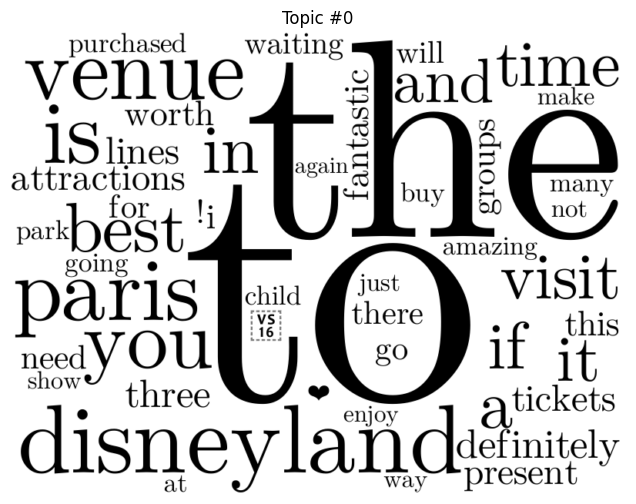

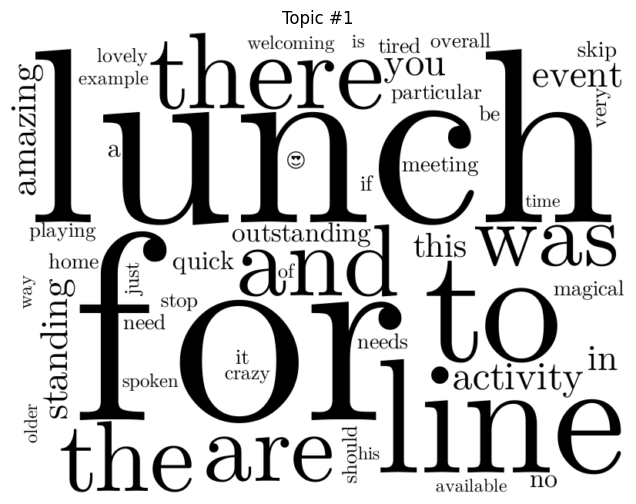

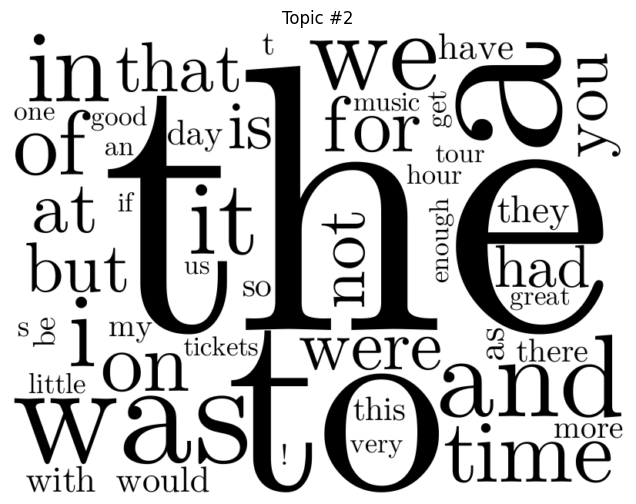

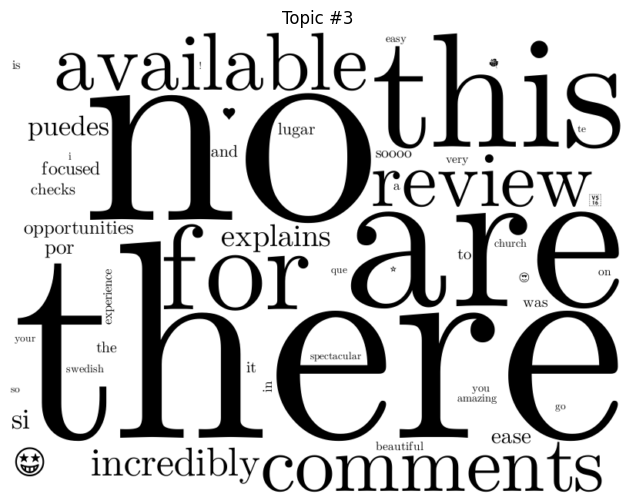

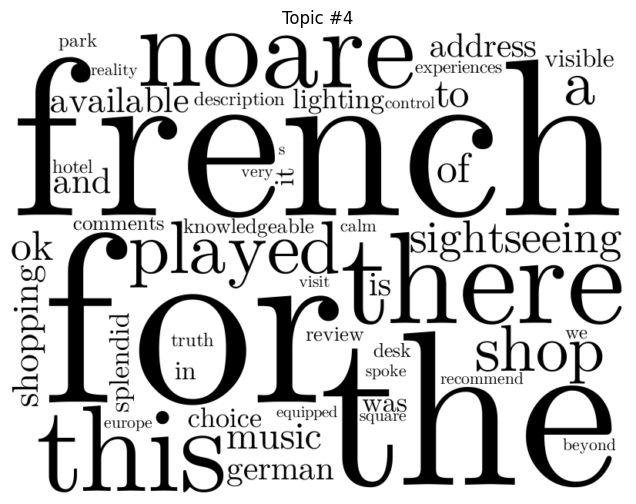

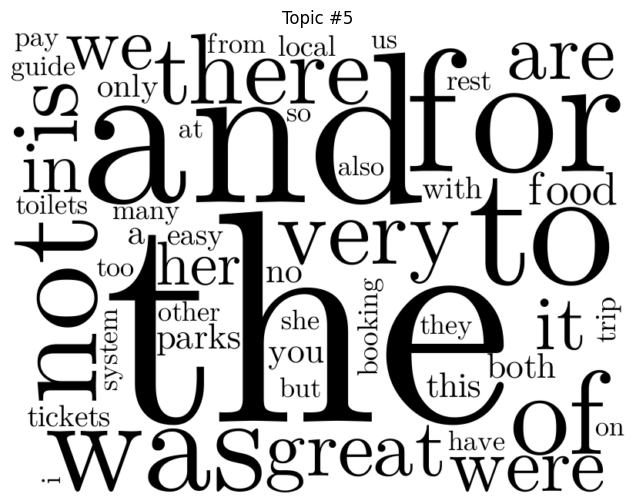

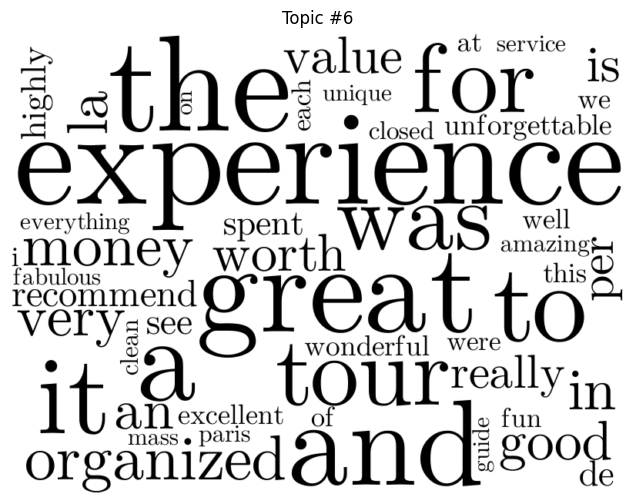

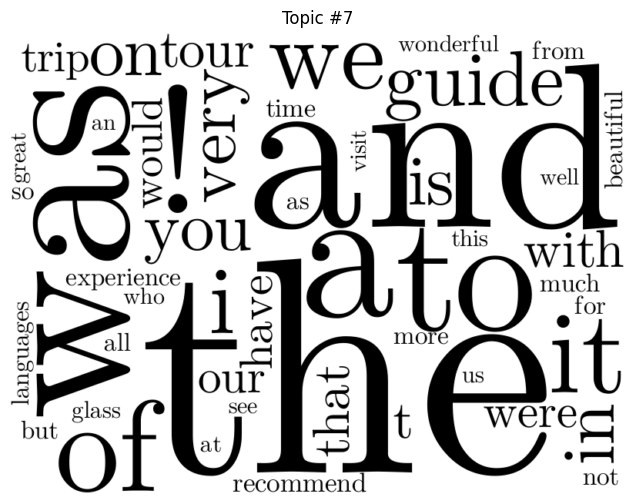

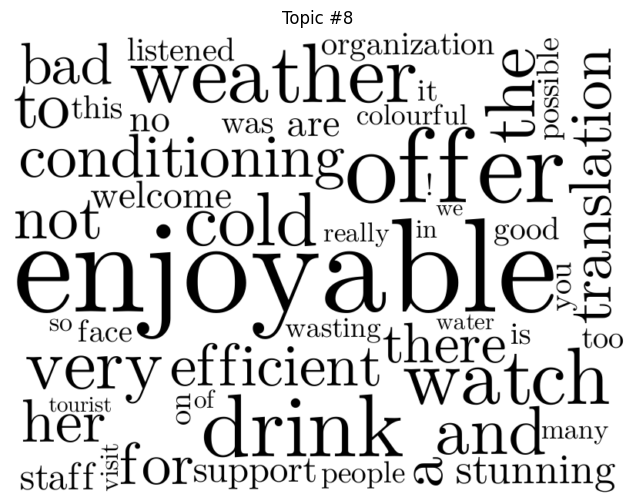

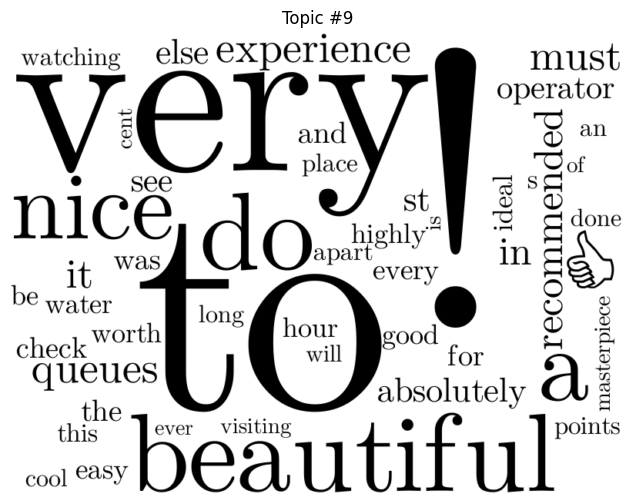

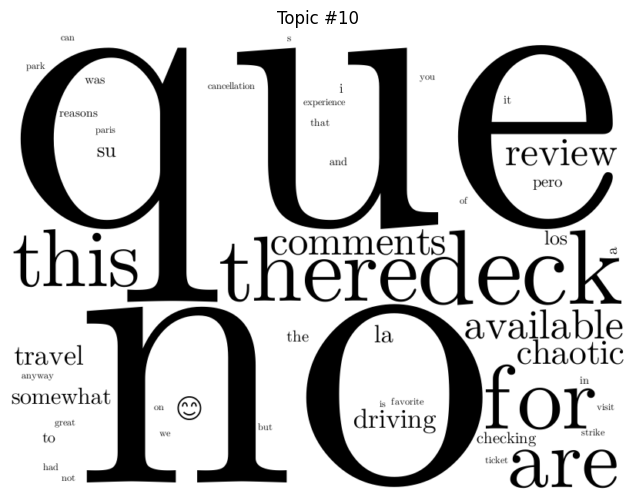

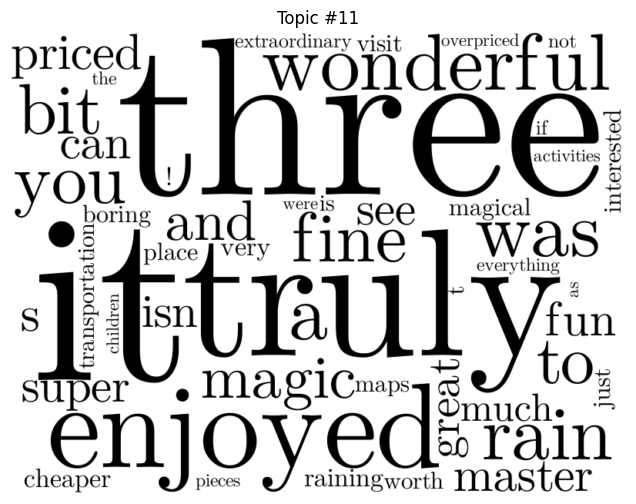

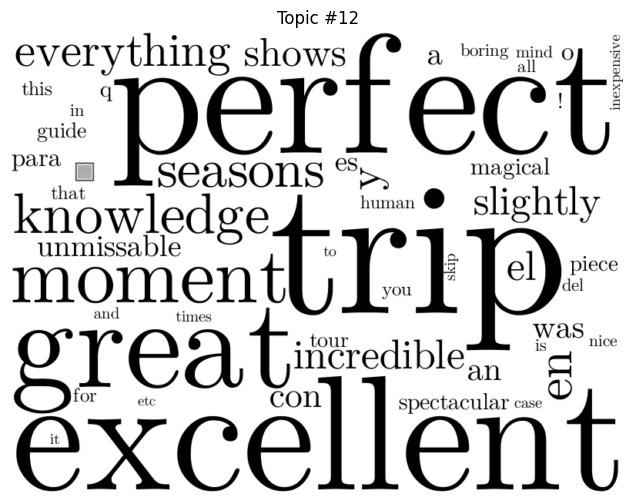

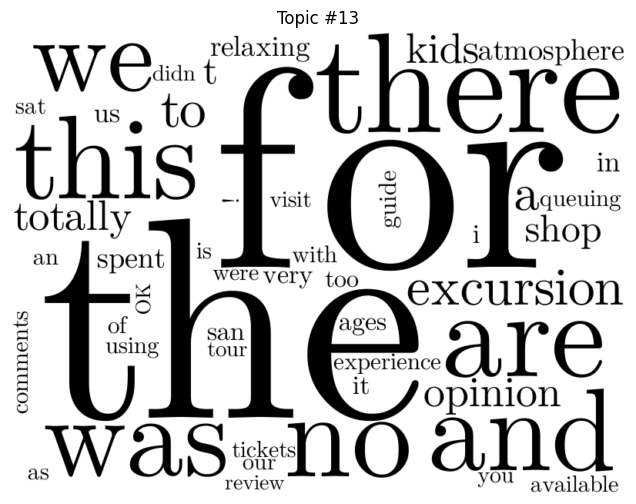

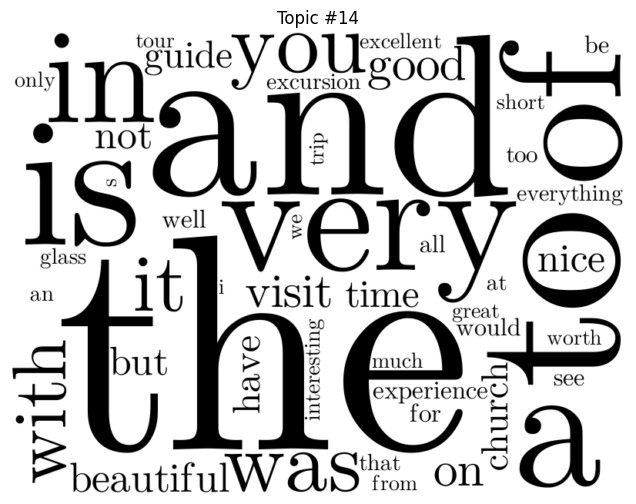

In [69]:
from wordcloud import WordCloud
import emojis

# Define a font path that supports emojis
font_path = 'C:/Users/surface/DSDM/Semesters/semester2/text mining/Final Project/emoj_Symbola/Symbola.otf'

def generate_wordclouds(topics, dictionary,font_path):
    for topic_num, topic_words in topics:
        word_freq = dict(topic_words)
        wordcloud = WordCloud(
            width=800,
            height=600,
            background_color='white',
            color_func=lambda *args, **kwargs: "black",  # Default color for non-emojis
            font_path=font_path,  # Specify emoji support
            min_font_size=10,
            regexp=r"\S+",  # Regular expression to include all non-whitespace characters
        ).generate_from_frequencies(word_freq)
        
        # Define a custom color function for emojis
        def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
            if word in emojis.UNICODE_EMOJI:  # Check if the word is an emoji
                return "lightblue"  # Set color for emojis
            else:
                return "black"  # Default color for non-emojis
        
        # Apply the custom color function
        wordcloud.color_func = color_func
        
        plt.figure(figsize=(8, 6), facecolor=None)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f'Topic #{topic_num}')
        plt.show()

# Generate word clouds for each topic
generate_wordclouds(topics, lda_model.id2word,font_path)

In [16]:
def custom_tokenizer_mod_1(text):
    tokens = tokenize(text, modulation=1)
    return tokens

from gensim import corpora, models
import pprint

# Tokenize the documents
tokenized_documents_mod1 = df_copy['Review_Body'].apply(custom_tokenizer_mod_1).tolist()

# Create dictionary and corpus
dictionary_mod1 = corpora.Dictionary(tokenized_documents_mod1)
corpus_mod1 = [dictionary_mod1.doc2bow(doc) for doc in tokenized_documents_mod1]

# Train the LDA model
lda_model_mod1 = models.LdaModel(corpus_mod1, num_topics= 15, id2word=dictionary_mod1)

# Print the topics
pprint.pprint(lda_model_mod1.print_topics())

[(0,
  '0.023*"would" + 0.020*"excurs" + 0.019*"see" + 0.016*"get" + 0.015*"good" + '
  '0.015*"wait" + 0.014*"go" + 0.014*"trip" + 0.013*"long" + 0.013*"well"'),
 (1,
  '0.048*"tour" + 0.044*"guid" + 0.020*"interest" + 0.019*"good" + '
  '0.018*"visit" + 0.017*"great" + 0.016*"excel" + 0.015*"enough" + '
  '0.014*"languag" + 0.013*"everyth"'),
 (2,
  '0.054*"cruis" + 0.021*"small" + 0.020*"ticket" + 0.017*"highlight" + '
  '0.017*"store" + 0.017*"peopl" + 0.016*"time" + 0.015*"watch" + 0.015*"mani" '
  '+ 0.014*"hour"'),
 (3,
  '0.093*"!" + 0.041*"beauti" + 0.037*"recommend" + 0.037*"experi" + '
  '0.034*"glass" + 0.027*"great" + 0.025*"nice" + 0.023*"trip" + 0.018*"high" '
  '+ 0.015*"visit"'),
 (4,
  '0.055*"good" + 0.038*"guid" + 0.031*"would" + 0.027*"experi" + 0.024*"time" '
  '+ 0.021*"nice" + 0.016*"general" + 0.016*"hear" + 0.015*"activ" + '
  '0.015*"languag"'),
 (5,
  '0.064*"time" + 0.026*"day" + 0.018*"pari" + 0.015*"hour" + 0.014*"ticket" + '
  '0.013*"one" + 0.012*"book"

### when we remove stop words and do stemming, importance of emojs in each topics is decreased and less than words. But, after removing stop words and do stemming, tokens in each topics give a better explanation

In [17]:
# Using get_document_topics with an explicit minimum_probability
doc_topics_mod1 = [lda_model_mod1.get_document_topics(item, minimum_probability=0.0000001) for item in corpus_mod1]

#note you could also use this vector = [lda[item] for item in corpus] but this has a higher threshold. 
#I like my topic vectors complete!

#this produces a lits of tuples
print(doc_topics_mod1[0])

[(0, 0.011883354), (1, 0.4973488), (2, 0.011883372), (3, 0.011883354), (4, 0.011883361), (5, 0.011883351), (6, 0.34816763), (7, 0.011883354), (8, 0.011883351), (9, 0.011883352), (10, 0.011883351), (11, 0.011883351), (12, 0.011883351), (13, 0.011883354), (14, 0.011883354)]


In [18]:
topics_mod1 = lda_model_mod1.show_topics(num_topics=-1, num_words=50, formatted=False)
#topics_mod1

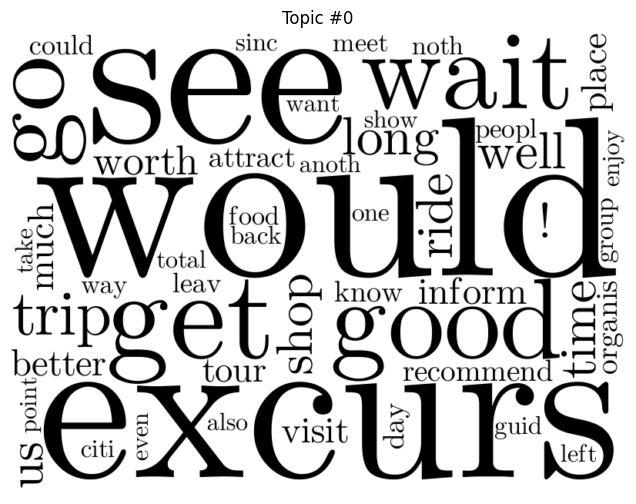

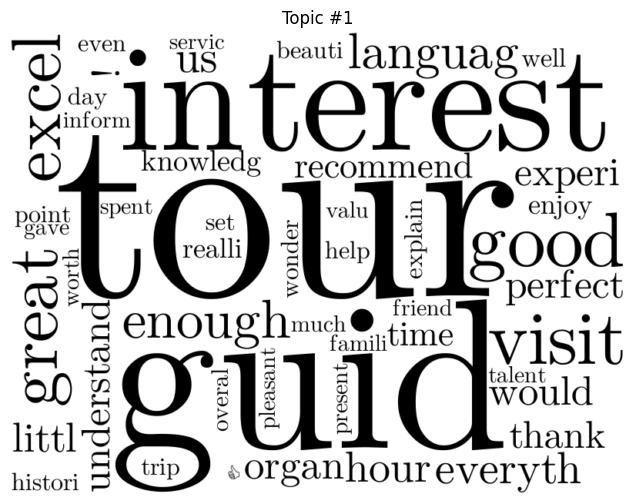

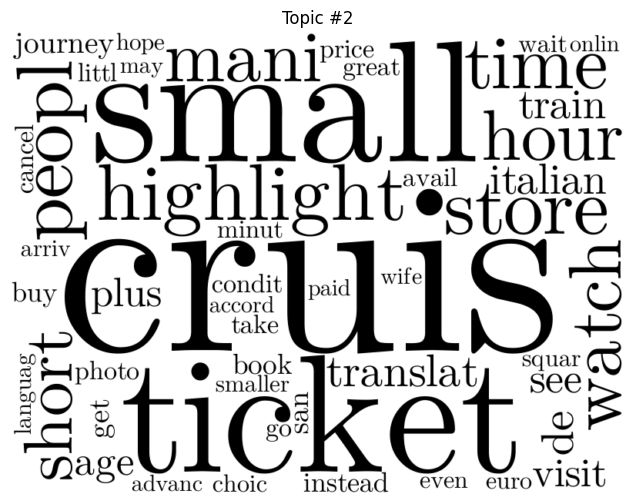

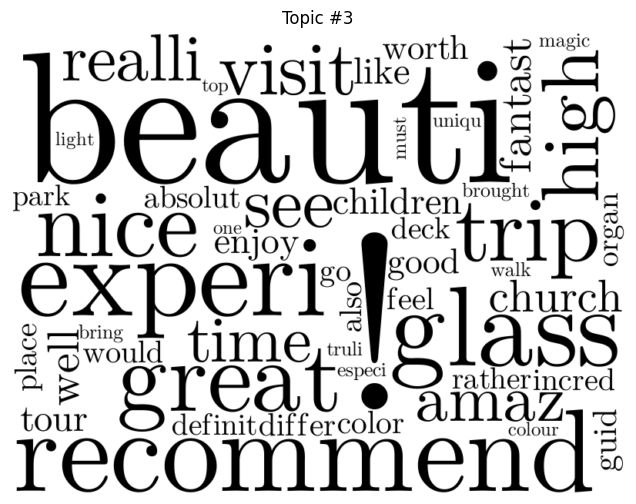

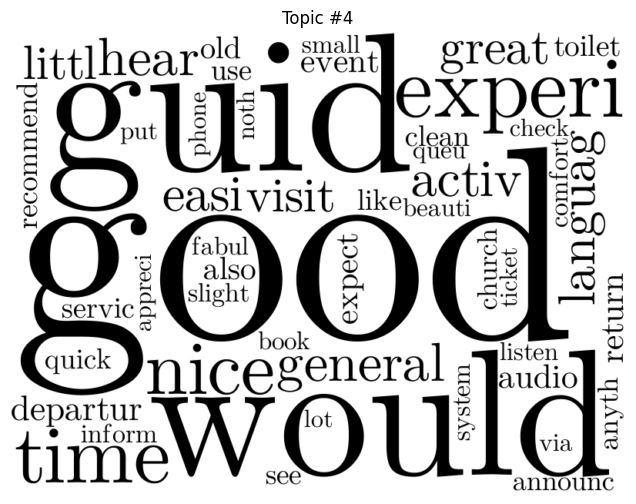

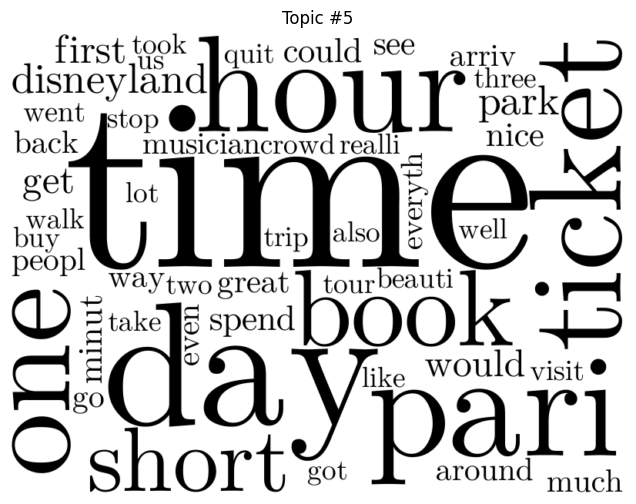

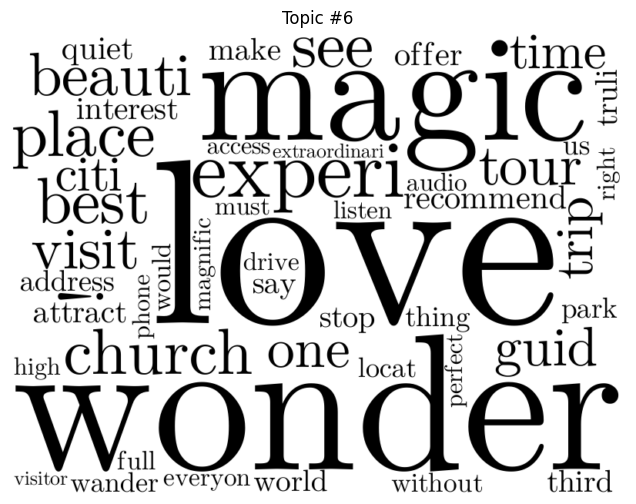

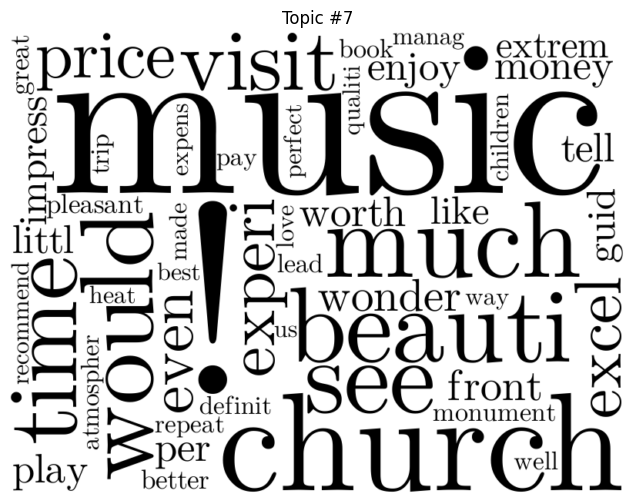

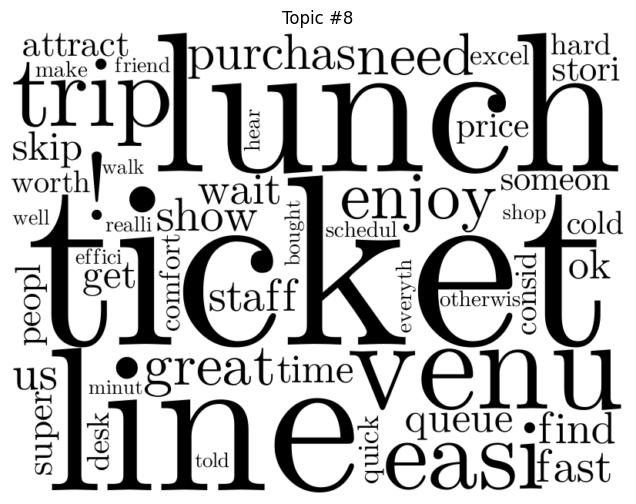

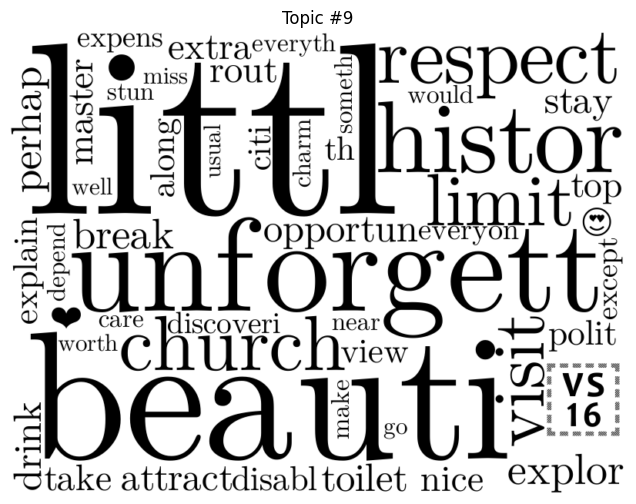

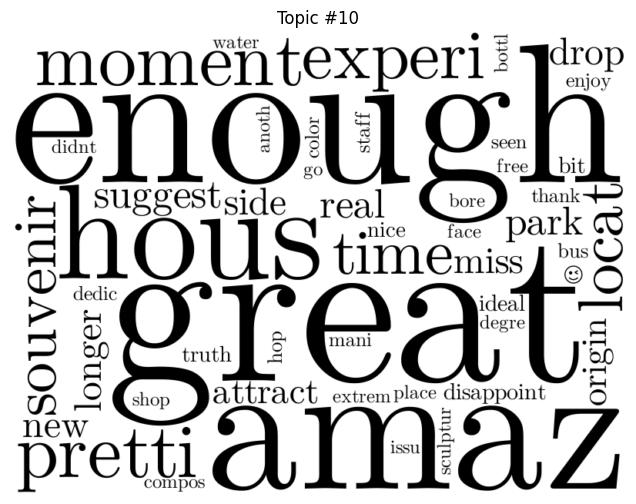

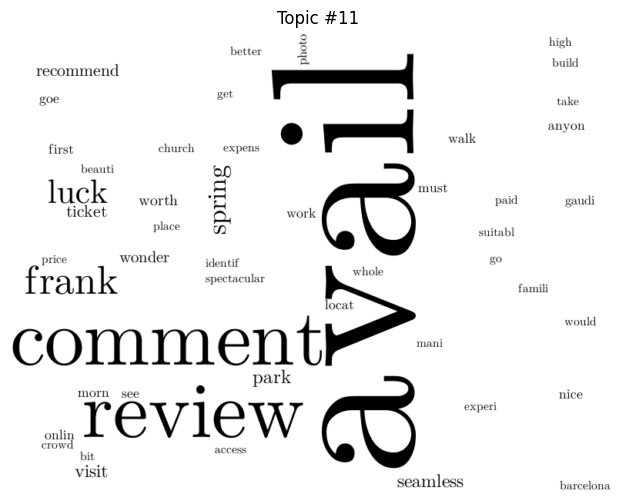

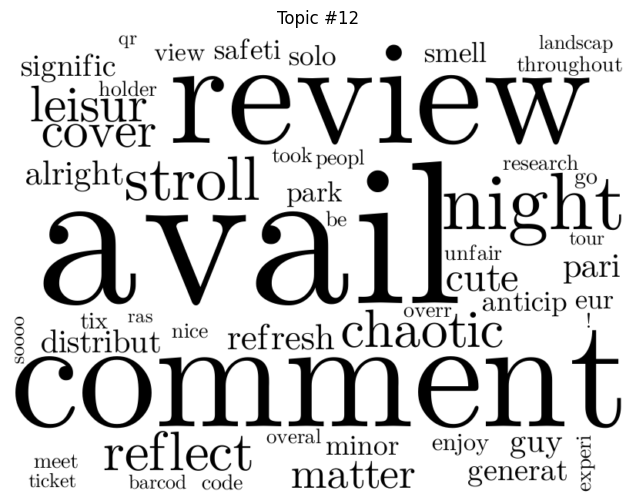

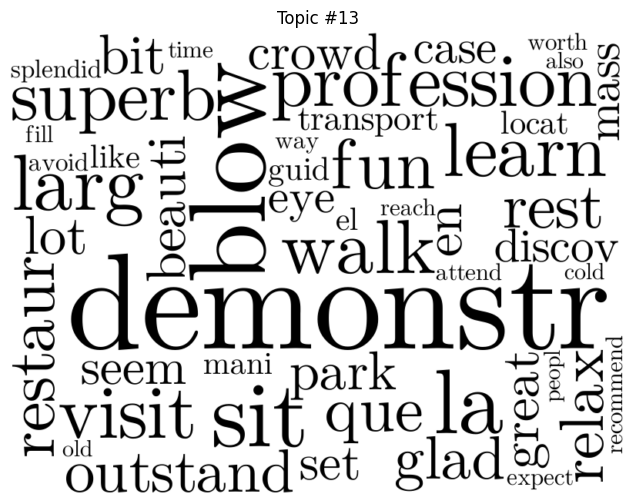

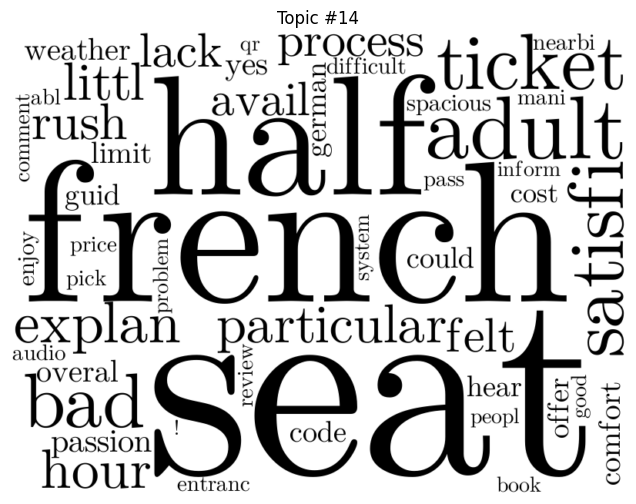

In [19]:
# Define a font path that supports emojis
font_path = 'C:/Users/surface/DSDM/Semesters/semester2/text mining/Final Project/emoj_Symbola/Symbola.otf'

# Generate word clouds for each topic
generate_wordclouds(topics_mod1, lda_model_mod1.id2word, font_path)